### Библиотеки

In [1]:
import pandas as pd
import numpy as np
import gc
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

### Загрузка всех входных данных сразу и сохранение их в формате dict: data{}

In [2]:

files = {
    "application_train": "application_train.csv",
    "application_test": "application_test.csv",
    "bureau": "bureau.csv",
    "bureau_balance": "bureau_balance.csv",
    "previous_application": "previous_application.csv",
    "POS_CASH_balance": "POS_CASH_balance.csv",
    "installments_payments": "installments_payments.csv",
    "credit_card_balance": "credit_card_balance.csv"
}

# Load all files into a dictionary
data = {}
for key, file in files.items():
    data[key] = pd.read_csv(file)
    print(f"{key} shape: {data[key].shape}")

application_train shape: (307511, 122)
application_test shape: (48744, 121)
bureau shape: (1716428, 17)
bureau_balance shape: (27299925, 3)
previous_application shape: (1670214, 37)
POS_CASH_balance shape: (10001358, 8)
installments_payments shape: (13605401, 8)
credit_card_balance shape: (3840312, 23)


### Проверка типов и соответствующих типов для всех наборов данных. У нас есть int, float и objects

In [3]:
# Function to print unique data types
def print_dtypes(df, dataset_name):
    print(f"\nUnique data types in {dataset_name}:")
    print(df.dtypes.value_counts())
    
# Find the data types present in all datasets
for key in data.keys():
    print_dtypes(data[key], key)


Unique data types in application_train:
float64    65
int64      41
object     16
Name: count, dtype: int64

Unique data types in application_test:
float64    65
int64      40
object     16
Name: count, dtype: int64

Unique data types in bureau:
float64    8
int64      6
object     3
Name: count, dtype: int64

Unique data types in bureau_balance:
int64     2
object    1
Name: count, dtype: int64

Unique data types in previous_application:
object     16
float64    15
int64       6
Name: count, dtype: int64

Unique data types in POS_CASH_balance:
int64      5
float64    2
object     1
Name: count, dtype: int64

Unique data types in installments_payments:
float64    5
int64      3
Name: count, dtype: int64

Unique data types in credit_card_balance:
float64    15
int64       7
object      1
Name: count, dtype: int64


Давайте посмотрим на типы объектов в данных application_train. Мы видим, что CODE_GENDER и ORGANIZATION TYPE интересны.
 Почему? Потому что CODE_GENDER имеет 3 значения, а ORGANIZATION_TYPE - 58 значений.
  После одной горячей кодировки ORGANIZATION_TYPE номера наших столбцов увеличатся

In [4]:
data['application_train'].select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [5]:
# Check unique Gender Type
data['application_train']['CODE_GENDER'].unique()

array(['M', 'F', 'XNA'], dtype=object)

In [6]:
# Select CODE GENDER not equals XNA
data['application_train'] = data['application_train'][data['application_train']['CODE_GENDER'] != 'XNA']
data['application_test'] = data['application_test'][data['application_test']['CODE_GENDER'] != 'XNA']

In [7]:
# Check unique Organization Types
data['application_train']['ORGANIZATION_TYPE'].unique()

array(['Business Entity Type 3', 'School', 'Government', 'Religion',
       'Other', 'XNA', 'Electricity', 'Medicine',
       'Business Entity Type 2', 'Self-employed', 'Transport: type 2',
       'Construction', 'Housing', 'Kindergarten', 'Trade: type 7',
       'Industry: type 11', 'Military', 'Services', 'Security Ministries',
       'Transport: type 4', 'Industry: type 1', 'Emergency', 'Security',
       'Trade: type 2', 'University', 'Transport: type 3', 'Police',
       'Business Entity Type 1', 'Postal', 'Industry: type 4',
       'Agriculture', 'Restaurant', 'Culture', 'Hotel',
       'Industry: type 7', 'Trade: type 3', 'Industry: type 3', 'Bank',
       'Industry: type 9', 'Insurance', 'Trade: type 6',
       'Industry: type 2', 'Transport: type 1', 'Industry: type 12',
       'Mobile', 'Trade: type 1', 'Industry: type 5', 'Industry: type 10',
       'Legal Services', 'Advertising', 'Trade: type 5', 'Cleaning',
       'Industry: type 13', 'Trade: type 4', 'Telecom',
       'I

Давайте посмотрим на корреляцию ORGANIZATION_TYPE с TARGET. 
Мы видим, что она имеет меньшую корреляцию с TARGET, но мы не знаем, можно ли считать эту корреляцию менее значимой на данный момент. 
Поэтому давайте сохраним ее.

In [8]:
# Check the correlation of ORGANIZATION TYPE ON TARGET)
# Extract the relevant columns
ext_data = data['application_train'][['TARGET', 'ORGANIZATION_TYPE']]
ext_data_encoded = pd.get_dummies(ext_data, columns=['ORGANIZATION_TYPE'], drop_first=True)

# Calculate correlations
ext_data_corrs = ext_data_encoded.corr()

# Display the correlation of the new features with the target
target_corr = ext_data_corrs['TARGET'].sort_values()

# Show the correlations with the target
print("Correlations with TARGET:")
print(target_corr)

Correlations with TARGET:
ORGANIZATION_TYPE_XNA                      -0.045989
ORGANIZATION_TYPE_School                   -0.013672
ORGANIZATION_TYPE_Medicine                 -0.010615
ORGANIZATION_TYPE_Military                 -0.010058
ORGANIZATION_TYPE_Police                   -0.009887
ORGANIZATION_TYPE_Bank                     -0.009610
ORGANIZATION_TYPE_Security Ministries      -0.009471
ORGANIZATION_TYPE_University               -0.007672
ORGANIZATION_TYPE_Government               -0.007521
ORGANIZATION_TYPE_Trade: type 6            -0.005788
ORGANIZATION_TYPE_Kindergarten             -0.005759
ORGANIZATION_TYPE_Industry: type 12        -0.005444
ORGANIZATION_TYPE_Industry: type 9         -0.005379
ORGANIZATION_TYPE_Services                 -0.003871
ORGANIZATION_TYPE_Insurance                -0.003850
ORGANIZATION_TYPE_Other                    -0.003785
ORGANIZATION_TYPE_Hotel                    -0.003410
ORGANIZATION_TYPE_Transport: type 1        -0.003375
ORGANIZATION_TYPE_Cu

EDA В DAYS_EMPLOYED данных application_train и test

Мы видим, что 365 243 - это максимальный рабочий день, что невозможно, поэтому замените его на NaN

In [10]:
# max value was 365243 which is not possible. Hence replace with NaN
data['application_train']['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
data['application_test']['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

### Check for missing values

In [11]:
# Function to check for missing values
def check_missing_values(df, dataset_name):
    missing_values = df.isnull().sum()
    missing_columns = missing_values[missing_values > 0].sort_values(ascending=False)  # Only show columns with missing values
    if not missing_columns.empty:
        print(f"\nMissing values in {dataset_name}:\n{missing_columns}")
    else:
        print(f"\nNo missing values in {dataset_name}.")
        
# Find the data types present in all datasets
for key in data.keys():
    check_missing_values(data[key], key)


Missing values in application_train:
COMMONAREA_MODE                 214862
COMMONAREA_AVG                  214862
COMMONAREA_MEDI                 214862
NONLIVINGAPARTMENTS_MEDI        213512
NONLIVINGAPARTMENTS_MODE        213512
NONLIVINGAPARTMENTS_AVG         213512
FONDKAPREMONT_MODE              210293
LIVINGAPARTMENTS_MEDI           210197
LIVINGAPARTMENTS_AVG            210197
LIVINGAPARTMENTS_MODE           210197
FLOORSMIN_AVG                   208640
FLOORSMIN_MEDI                  208640
FLOORSMIN_MODE                  208640
YEARS_BUILD_MEDI                204486
YEARS_BUILD_MODE                204486
YEARS_BUILD_AVG                 204486
OWN_CAR_AGE                     202927
LANDAREA_MODE                   182588
LANDAREA_MEDI                   182588
LANDAREA_AVG                    182588
BASEMENTAREA_MEDI               179942
BASEMENTAREA_MODE               179942
BASEMENTAREA_AVG                179942
EXT_SOURCE_1                    173376
NONLIVINGAREA_AVG         

Мы обнаружили, что в наборах данных отсутствует множество значений. Давайте проверим процентные соотношения

In [12]:
# Function to check the percentage of missing values
def check_missing_percentage(df):
    missing_percentage = 100 * df.isnull().sum() / len(df)
    missing_columns = missing_percentage[missing_percentage > 0].sort_values(ascending=False) 
    return missing_columns

# Check missing percentage for each dataset
for key in data.keys():
    print(f"\nMissing value percentages in {key}:")
    missing_percentage = check_missing_percentage(data[key])
    print(missing_percentage)


Missing value percentages in application_train:
COMMONAREA_MODE                 69.872231
COMMONAREA_AVG                  69.872231
COMMONAREA_MEDI                 69.872231
NONLIVINGAPARTMENTS_MEDI        69.433216
NONLIVINGAPARTMENTS_MODE        69.433216
NONLIVINGAPARTMENTS_AVG         69.433216
FONDKAPREMONT_MODE              68.386411
LIVINGAPARTMENTS_MEDI           68.355192
LIVINGAPARTMENTS_AVG            68.355192
LIVINGAPARTMENTS_MODE           68.355192
FLOORSMIN_AVG                   67.848862
FLOORSMIN_MEDI                  67.848862
FLOORSMIN_MODE                  67.848862
YEARS_BUILD_MEDI                66.497998
YEARS_BUILD_MODE                66.497998
YEARS_BUILD_AVG                 66.497998
OWN_CAR_AGE                     65.991018
LANDAREA_MODE                   59.376860
LANDAREA_MEDI                   59.376860
LANDAREA_AVG                    59.376860
BASEMENTAREA_MEDI               58.516391
BASEMENTAREA_MODE               58.516391
BASEMENTAREA_AVG           

Мы удаляем столбцы, содержащие более 75% пропущенных значений. Возможно, мы потеряем какую-то информацию, но и сохранять ее не имеет смысла.

In [13]:
# Function to handle missing values
def handle_missing_values(df):
    # Drop columns with more than 30% missing values
    threshold = 0.75
    cols_to_drop = df.columns[df.isnull().mean() > threshold]
    df.drop(columns=cols_to_drop, inplace=True)
    print(f"Dropped columns with more than {threshold*100}% missing values: {list(cols_to_drop)}")
    return df

# Apply missing value handling to all datasets
for key in data.keys():
    print(f"\nHandling missing values for {key} dataset...")
    data[key] = handle_missing_values(data[key])
    print(f"Processed {key} dataset. Final shape: {data[key].shape}")


Handling missing values for application_train dataset...
Dropped columns with more than 75.0% missing values: []
Processed application_train dataset. Final shape: (307507, 122)

Handling missing values for application_test dataset...
Dropped columns with more than 75.0% missing values: []
Processed application_test dataset. Final shape: (48744, 121)

Handling missing values for bureau dataset...
Dropped columns with more than 75.0% missing values: []
Processed bureau dataset. Final shape: (1716428, 17)

Handling missing values for bureau_balance dataset...
Dropped columns with more than 75.0% missing values: []
Processed bureau_balance dataset. Final shape: (27299925, 3)

Handling missing values for previous_application dataset...
Dropped columns with more than 75.0% missing values: ['RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED']
Processed previous_application dataset. Final shape: (1670214, 35)

Handling missing values for POS_CASH_balance dataset...
Dropped columns with more t

In [14]:
# Function to encode categorical columns and print shapes
def encode_categorical_features(df, dataset_name):

    # Get the shape before encoding
    initial_shape = df.shape
    
    # Get the categorical columns (type object)
    cat_cols = df.select_dtypes(include=['object']).columns
    le = LabelEncoder()

    print(f"\nInitial shape: {initial_shape}")
    print(f"Found {len(cat_cols)} categorical columns to encode: {list(cat_cols)}")
    
    for col in cat_cols:
        # If column has only two unique values, apply Label Encoding
        if df[col].nunique() == 2:
            df[col] = le.fit_transform(df[col])
            print(f"Label Encoding applied to column: {col}")
        else:
            # Apply One-Hot Encoding for multi-category columns
            df = pd.get_dummies(df, columns=[col], drop_first=True)
            print(f"One-Hot Encoding applied to column: {col}")
    
    # Convert any Boolean columns to integers (0 and 1)
    for col in df.select_dtypes(include=[bool]).columns:
        df[col] = df[col].astype(int)
        
    # Get the shape after encoding
    final_shape = df.shape
    print(f"Final shape after encoding: {final_shape}")
    
    return df

# Apply encoding to all datasets
for key in data.keys():
    print(f"\nProcessing {key} dataset...")
    data[key] = encode_categorical_features(data[key], key)
    print(f"Processed {key} dataset. Final shape: {data[key].shape}")


Processing application_train dataset...

Initial shape: (307507, 122)
Found 16 categorical columns to encode: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
Label Encoding applied to column: NAME_CONTRACT_TYPE
Label Encoding applied to column: CODE_GENDER
Label Encoding applied to column: FLAG_OWN_CAR
Label Encoding applied to column: FLAG_OWN_REALTY
One-Hot Encoding applied to column: NAME_TYPE_SUITE
One-Hot Encoding applied to column: NAME_INCOME_TYPE
One-Hot Encoding applied to column: NAME_EDUCATION_TYPE
One-Hot Encoding applied to column: NAME_FAMILY_STATUS
One-Hot Encoding applied to column: NAME_HOUSING_TYPE
One-Hot Encoding applied to column: OCCUPATION_TYPE
One-Hot Encoding applied to column: WE

In [15]:
# Lets take a look at sample train data. We see there are no cat variables here
data['application_train'].head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry:

## Давайте выясним некоторые важные особенности, необходимые для проведения корреляционного анализа

In [16]:
# Find correlations with the target and sort
correlations = data['application_train'].corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(5))
print('\nMost Negative Correlations:\n', correlations.head(5))

Most Positive Correlations:
 REGION_RATING_CLIENT           0.058901
REGION_RATING_CLIENT_W_CITY    0.060895
DAYS_EMPLOYED                  0.074957
DAYS_BIRTH                     0.078242
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                           -0.178926
EXT_SOURCE_2                           -0.160471
EXT_SOURCE_1                           -0.155317
NAME_EDUCATION_TYPE_Higher education   -0.056593
NAME_INCOME_TYPE_Pensioner             -0.046211
Name: TARGET, dtype: float64


Мы видим, что важны EXT Sources и DAYS birth

Молодые люди имеют более высокие шансы на банкротство, чем пожилые

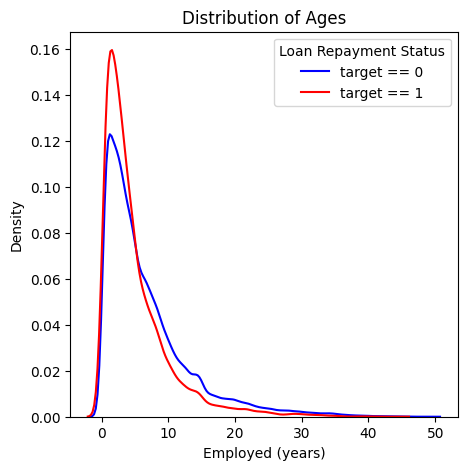

In [18]:
# Create the plot
plt.figure(figsize=(5, 5))

# Ensure DAYS_BIRTH is positive
data['application_train']['DAYS_EMPLOYED'] = abs(data['application_train']['DAYS_EMPLOYED'])
data['application_train']['DAYS_EMPLOYED'].corr(data['application_train']['TARGET'])
# KDE plot of loans repaid on time
sns.kdeplot(data['application_train'].loc[data['application_train']['TARGET'] == 0, 'DAYS_EMPLOYED'] / 365, label='target == 0', color='blue')

# KDE plot of loans not repaid on time
sns.kdeplot(data['application_train'].loc[data['application_train']['TARGET'] == 1, 'DAYS_EMPLOYED'] / 365, label='target == 1', color='red')

# Labeling the plot
plt.xlabel('Employed (years)')
plt.ylabel('Density')
plt.title('Distribution of Ages')

# Add a legend to differentiate between the two plots
plt.legend(title="Loan Repayment Status")

# Display the plot
plt.show()


In [19]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = data['application_train'][['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'DAYS_EMPLOYED']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_EMPLOYED
TARGET,1.000000,-0.155317,-0.160471,-0.178926,-0.078242,-0.074957
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186845,0.600621,0.252711
EXT_SOURCE_2,-0.160471,0.213982,1.000000,0.109182,0.092009,0.093463
EXT_SOURCE_3,-0.178926,0.186845,0.109182,1.000000,0.205465,0.129725
DAYS_BIRTH,-0.078242,0.600621,0.092009,0.205465,1.000000,0.352311
DAYS_EMPLOYED,-0.074957,0.252711,0.093463,0.129725,0.352311,1.000000


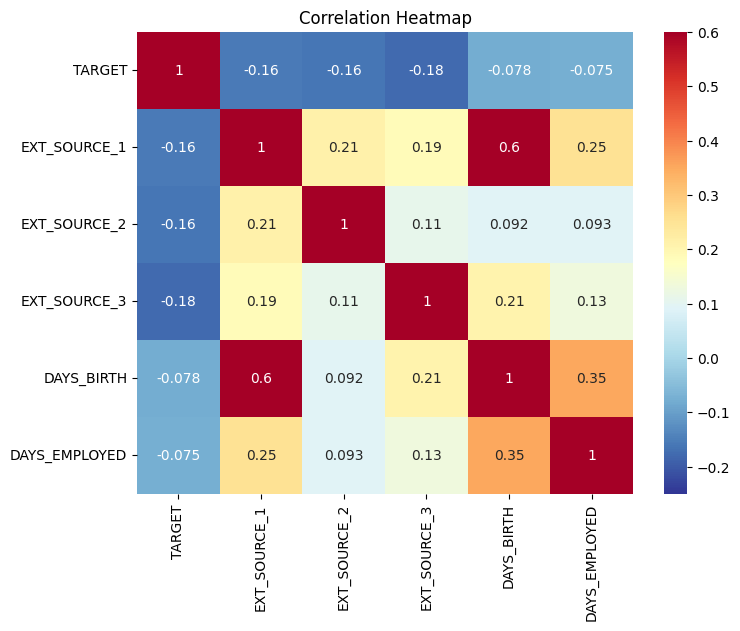

In [20]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

In [22]:
data['previous_application'].head()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_XNA,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,NAME_CASH_LOAN_PURPOSE_Business development,NAME_CASH_LOAN_PURPOSE_Buying a garage,NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land,NAME_CASH_LOAN_PURPOSE_Buying a home,NAME_CASH_LOAN_PURPOSE_Buying a new car,NAME_CASH_LOAN_PURPOSE_Buying a used car,NAME_CASH_LOAN_PURPOSE_Car repairs,NAME_CASH_LOAN_PURPOSE_Education,NAME_CASH_LOAN_PURPOSE_Everyday expenses,NAME_CASH_LOAN_PURPOSE_Furniture,NAME_CASH_LOAN_PURPOSE_Gasification / water supply,NAME_CASH_LOAN_PURPOSE_Hobby,NAME_CASH_LOAN_PURPOSE_Journey,NAME_CASH_LOAN_PURPOSE_Medicine,NAME_CASH_LOAN_PURPOSE_Money for a third person,NAME_CASH_LOAN_PURPOSE_Other,NAME_CASH_LOAN_PURPOSE_Payments on other loans,NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment,NAME_CASH_LOAN_PURPOSE_Refusal to name the goal,NAME_CASH_LOAN_PURPOSE_Repairs,NAME_CASH_LOAN_PURPOSE_Urgent needs,NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday,NAME_CASH_LOAN_PURPOSE_XAP,NAME_CASH_LOAN_PURPOSE_XNA,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_PAYMENT_TYPE_Cashless from the account of the employer,NAME_PAYMENT_TYPE_Non-cash from your account,NAME_PAYMENT_TYPE_XNA,CODE_REJECT_REASON_HC,CODE_REJECT_REASON_LIMIT,CODE_REJECT_REASON_SCO,CODE_REJECT_REASON_SCOFR,CODE_REJECT_REASON_SYSTEM,CODE_REJECT_REASON_VERIF,CODE_REJECT_REASON_XAP,CODE_REJECT_REASON_XNA,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,NAME_CLIENT_TYPE_XNA,NAME_GOODS_CATEGORY_Animals,NAME_GOODS_CATEGORY_Audio/Video,NAME_GOODS_CATEGORY_Auto Accessories,NAME_GOODS_CATEGORY_Clothing and Accessories,NAME_GOODS_CATEGORY_Computers,NAME_GOODS_CATEGORY_Construction Materials,NAME_GOODS_CATEGORY_Consumer Electronics,NAME_GOODS_CATEGORY_Direct Sales,NAME_GOODS_CATEGORY_Education,NAME_GOODS_CATEGORY_Fitness,NAME_GOODS_CATEGORY_Furniture,NAME_GOODS_CATEGORY_Gardening,NAME_GOODS_CATEGORY_Homewares,NAME_GOODS_CATEGORY_House Construction,NAME_GOODS_CATEGORY_Insurance,NAME_GOODS_CATEGORY_Jewelry,NAME_GOODS_CATEGORY_Medical Supplies,NAME_GOODS_CATEGORY_Medicine,NAME_GOODS_CATEGORY_Mobile,NAME_GOODS_CATEGORY_Office Appliances,NAME_GOODS_CATEGORY_Other,NAME_GOODS_CATEGORY_Photo / Cinema Equipment,NAME_GOODS_CATEGORY_Sport and Leisure,NAME_GOODS_CATEGORY_Tourism,NAME_GOODS_CATEGORY_Vehicles,NAME_GOODS_CATEGORY_Weapon,NAME_GOODS_CATEGORY_XNA,NAME_PORTFOLIO_Cars,NAME_PORTFOLIO_Cash,NAME_PORTFOLIO_POS,NAME_PORTFOLIO_XNA,NAME_PRODUCT_TYPE_walk-in,NAME_PRODUCT_TYPE_x-sell,CHANNEL_TYPE_Car dealer,CHANNEL_TYPE_Channel of corporate sales,CHANNEL_TYPE_Contact center,CHANNEL_TYPE_Country-wide,CHANNEL_TYPE_Credit and cash offices,CHANNEL_TYPE_Regional / Local,CHANNEL_TYPE_Stone,NAME_SELLER_INDUSTRY_Clothing,NAME_SELLER_INDUSTRY_Connectivity,NAME_SELLER_INDUSTRY_Construction,NAME_SELLER_INDUSTRY_Consumer electronics,NAME_SELLER_INDUSTRY_Furniture,NAME_SELLER_INDUSTRY_Industry,NAME_SELLER_INDUSTRY_Jewelry,NAME_SELLER_INDUSTRY_MLM partners,NAME_SELLER_INDUSTRY_Tourism,NAME_SELLER_INDUSTRY_XNA,NAME_YIELD_GROUP_high,NAME_YIELD_GROUP_low_action,NAME_YIELD_GROUP_low_normal,NAME_YIELD_GROUP_middle,PRODUCT_COMBINATION_Card X-Sell,PRODUCT_COMBINATION_Cash,PRODUCT_COMBINATION_Cash Street: high,PRODUCT_COMBINATION_Cash Stree

In [23]:
# Check the columns for reasonable values
print(data['previous_application']['DAYS_FIRST_DRAWING'].describe())
print(data['previous_application']['DAYS_FIRST_DUE'].describe())
print(data['previous_application']['DAYS_LAST_DUE_1ST_VERSION'].describe())
print(data['previous_application']['DAYS_LAST_DUE'].describe())
print(data['previous_application']['DAYS_TERMINATION'].describe())

count    997149.000000
mean     342209.855039
std       88916.115833
min       -2922.000000
25%      365243.000000
50%      365243.000000
75%      365243.000000
max      365243.000000
Name: DAYS_FIRST_DRAWING, dtype: float64
count    997149.000000
mean      13826.269337
std       72444.869708
min       -2892.000000
25%       -1628.000000
50%        -831.000000
75%        -411.000000
max      365243.000000
Name: DAYS_FIRST_DUE, dtype: float64
count    997149.000000
mean      33767.774054
std      106857.034789
min       -2801.000000
25%       -1242.000000
50%        -361.000000
75%         129.000000
max      365243.000000
Name: DAYS_LAST_DUE_1ST_VERSION, dtype: float64
count    997149.000000
mean      76582.403064
std      149647.415123
min       -2889.000000
25%       -1314.000000
50%        -537.000000
75%         -74.000000
max      365243.000000
Name: DAYS_LAST_DUE, dtype: float64
count    997149.000000
mean      81992.343838
std      153303.516729
min       -2874.000000
25%       

In [24]:
data['previous_application']['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
data['previous_application']['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
data['previous_application']['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
data['previous_application']['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
data['previous_application']['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

 Обработать другие пропущенные значения с помощью fillna

In [25]:
# Function to handle missing values
def impute_cols_with_nas(df):
    # Impute missing values for numerical columns with the median
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    for col in num_cols:
        df[col].fillna(df[col].median(), inplace=True)
        
    # Impute missing values for categorical columns with the mode
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)

# Impute columns with NAs for each dataset
for key in data.keys():
    impute_cols_with_nas(data[key])

Категориальное кодирование может изменить количество функций при обучении и тестировании, поэтому выровняйте их так, чтобы они не вызывали проблем при построении модели

In [26]:
train_labels = data['application_train']['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
data['application_train'], data['application_test'] = data['application_train'].align(data['application_test'], join = 'inner', axis = 1)

# Add the target back in
data['application_train']['TARGET'] = train_labels

print('Training Features shape: ', data['application_train'].shape)
print('Testing Features shape: ', data['application_test'].shape)

Training Features shape:  (307507, 227)
Testing Features shape:  (48744, 226)


In [27]:
# Check missing percentage for each dataset
for key in data.keys():
    print(f"\nMissing value percentages in {key}:")
    missing_percentage = check_missing_percentage(data[key])
    print(missing_percentage)


Missing value percentages in application_train:
Series([], dtype: float64)

Missing value percentages in application_test:
Series([], dtype: float64)

Missing value percentages in bureau:
Series([], dtype: float64)

Missing value percentages in bureau_balance:
Series([], dtype: float64)

Missing value percentages in previous_application:
Series([], dtype: float64)

Missing value percentages in POS_CASH_balance:
Series([], dtype: float64)

Missing value percentages in installments_payments:
Series([], dtype: float64)

Missing value percentages in credit_card_balance:
Series([], dtype: float64)


### Модели

In [29]:
y_train = data['application_train']['TARGET']
X_train = data['application_train'].drop(columns=['TARGET', 'SK_ID_CURR'])  # Drop target and identifier

# Splitting the training data into train and validation sets
X_train_split, X_valid, y_train_split, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [30]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
}

# Train and evaluate models
for model_name, model in models.items():
    model.fit(X_train_split, y_train_split)
    y_pred_valid = model.predict_proba(X_valid)[:, 1]
    roc_auc = roc_auc_score(y_valid, y_pred_valid)
    print(f"{model_name} ROC AUC: {roc_auc:.4f}")

Logistic Regression ROC AUC: 0.6316
Random Forest ROC AUC: 0.7130
XGBoost ROC AUC: 0.7510



### Logistic Regression ROC AUC: 0.6316
### Random Forest ROC AUC: 0.7130
### XGBoost ROC AUC: 0.7510

### DNN

In [31]:
def create_dnn_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, input_dim=input_shape, activation='relu'),
        tf.keras.layers.Dropout(0.3),  # Dropout for regularization
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    return model

# Shape of the input data
input_shape = X_train_split.shape[1]

# Initialize the DNN model
dnn_model = create_dnn_model(input_shape)

# Early stopping callback - stop training when validation AUC does not improve for 3 consecutive epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',  # Track validation AUC
    patience=3,         # Number of epochs with no improvement to stop training
    mode='max',         # We want to maximize AUC
    restore_best_weights=True  # Restore model weights from the epoch with the best AUC
)

# Train the DNN model with early stopping
dnn_model.fit(
    X_train_split, y_train_split, 
    epochs=10,                  # Set a higher max number of epochs
    batch_size=264, 
    validation_data=(X_valid, y_valid), 
    callbacks=[early_stopping],  # Add the early stopping callback
    verbose=1
)

# Evaluate the DNN model on validation data
y_pred_valid_dnn = dnn_model.predict(X_valid).ravel()  # Flatten the array for roc_auc_score
roc_auc_dnn = roc_auc_score(y_valid, y_pred_valid_dnn)

print(f"Deep Neural Network ROC AUC: {roc_auc_dnn:.4f}")

Epoch 1/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.5005 - loss: 1840.6213 - val_AUC: 0.4955 - val_loss: 0.9744
Epoch 2/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.4994 - loss: 21.5847 - val_AUC: 0.4986 - val_loss: 0.3008
Epoch 3/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.4991 - loss: 1.7250 - val_AUC: 0.5000 - val_loss: 0.2810
Epoch 4/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.5005 - loss: 0.7831 - val_AUC: 0.5000 - val_loss: 0.2805
Epoch 5/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.4999 - loss: 0.5309 - val_AUC: 0.5000 - val_loss: 0.2805
Epoch 6/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.4984 - loss: 0.9817 - val_AUC: 0.5000 - val_loss: 0.2806
Epoch 7/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.4986 - loss: 0.4319 - val_AUC: 0.5000 - val_loss: 0.2806
Epoch 8/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.5015 - loss: 0.3824 - val_AUC: 0.5000 - val_loss: 0.2805
Epoch 9/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step 

Мы видим, что ROC AUC глубоких нейронных сетей при проверке равен 0,5. Что в основном означает, что он ведет себя случайным образом.

Теперь давайте масштабируем данные и посмотрим, как ведут себя модели.
 Я использовал StandardScaler

In [32]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and validation data
X_train_scaled = scaler.fit_transform(X_train_split)
X_valid_scaled = scaler.transform(X_valid)

Давайте обучим логистическую регрессию, Случайный лес, XGBoost и DNNs на основе данных X_train_scaled и протестируем на данных X_valid_scaled.
 Примечание: Данные теперь масштабируются. Но мы по-прежнему имеем дело только с данными приложения для обучения. До сих пор мы не использовали никаких других данных.

In [33]:
# Train and evaluate models
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train_split)
    y_pred_valid = model.predict_proba(X_valid_scaled)[:, 1]
    roc_auc = roc_auc_score(y_valid, y_pred_valid)
    print(f"{model_name} ROC AUC: {roc_auc:.4f}")

Logistic Regression ROC AUC: 0.7491
Random Forest ROC AUC: 0.7131
XGBoost ROC AUC: 0.7510



### Logistic Regression ROC AUC: 0.7491
### Random Forest ROC AUC: 0.7131
### XGBoost ROC AUC: 0.7510

После масштабирования мы получаем следующие результаты. Мы видим, что производительность логистической регрессии значительно возросла только за счет масштабирования данных. С другой стороны, масштабирование не влияет на два других алгоритма, поскольку они сами заботятся об этом.

In [34]:
def create_optimized_dnn_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, input_dim=input_shape, activation='relu'),
        tf.keras.layers.Dropout(0.4),  # Increased dropout for regularization
        tf.keras.layers.BatchNormalization(),  # Batch normalization
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])
    
    # Compile the model with a different learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
                  loss='binary_crossentropy', 
                  metrics=['AUC'])
    return model

input_shape = X_train_scaled.shape[1]

# Initialize the optimized DNN model
optimized_dnn_model = create_optimized_dnn_model(input_shape)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    patience=3,  # Increased patience
    mode='max',
    restore_best_weights=True
)

# Train the optimized DNN model with early stopping and learning rate scheduler
history = optimized_dnn_model.fit(
    X_train_scaled, y_train_split,
    epochs=10, 
    batch_size=264,
    validation_data=(X_valid_scaled, y_valid),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the optimized DNN model on validation data
y_pred_valid_dnn = optimized_dnn_model.predict(X_valid_scaled).ravel()  # Flatten the array for roc_auc_score
roc_auc_dnn = roc_auc_score(y_valid, y_pred_valid_dnn)

print(f"Optimized Deep Neural Network ROC AUC: {roc_auc_dnn:.4f}")

Epoch 1/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - AUC: 0.6591 - loss: 0.2814 - val_AUC: 0.7427 - val_loss: 0.2519
Epoch 2/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.7359 - loss: 0.2530 - val_AUC: 0.7442 - val_loss: 0.2512
Epoch 3/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - AUC: 0.7402 - loss: 0.2498 - val_AUC: 0.7466 - val_loss: 0.2505
Epoch 4/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - AUC: 0.7400 - loss: 0.2526 - val_AUC: 0.7456 - val_loss: 0.2516
Epoch 5/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - AUC: 0.7403 - loss: 0.2533 - val_AUC: 0.7480 - val_loss: 0.2498
Epoch 6/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - AUC: 0.7452 - loss: 0.2491 - val_AUC: 0.7476 - val_loss: 0.2495
Epoch 7/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - AUC: 0.7479 - loss: 0.2519 - val_AUC: 0.7456 - val_loss: 0.2505
Epoch 8/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - AUC: 0.7493 - loss: 0.2492 - val_AUC: 0.7463 - val_loss: 0.2512
Epoch 9/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - AU

Теперь мы можем видеть, что наша глубокая нейронная сеть выдала нам ROC AUC 0,7483 для данных проверки с масштабированием и только для данных application_train без previous_loan и т.д.

### We know that we are dealing with highly imbalanced problem

TARGET
0    282682
1     24825
Name: count, dtype: int64


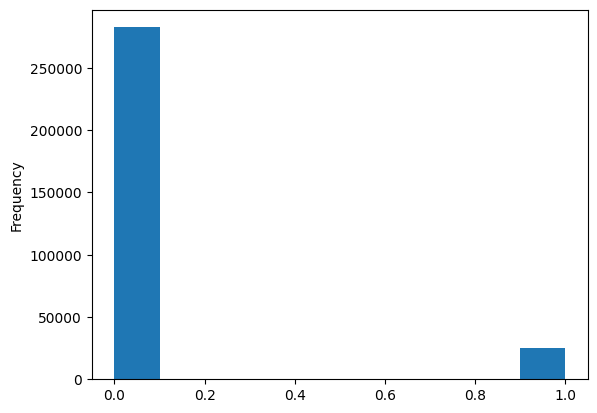

In [35]:
print(data['application_train']['TARGET'].value_counts())
data['application_train']['TARGET'].astype(int).plot.hist();

### применим SMOTE

In [36]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training split
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train_split)

# Print class distribution after SMOTE
print("After SMOTE:", Counter(y_train_resampled))

After SMOTE: Counter({0: 226145, 1: 226145})


In [37]:
# Train and evaluate models
for model_name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred_valid = model.predict_proba(X_valid_scaled)[:, 1]
    roc_auc = roc_auc_score(y_valid, y_pred_valid)
    print(f"{model_name} ROC AUC: {roc_auc:.4f}")

Logistic Regression ROC AUC: 0.7414
Random Forest ROC AUC: 0.7023
XGBoost ROC AUC: 0.7469


In [38]:
input_shape = X_train_resampled.shape[1]

# Initialize the optimized DNN model
optimized_dnn_model = create_optimized_dnn_model(input_shape)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    patience=3,  # Increased patience
    mode='max',
    restore_best_weights=True
)

# Train the optimized DNN model with early stopping and learning rate scheduler
history = optimized_dnn_model.fit(
    X_train_resampled, y_train_resampled,
    epochs=10, 
    batch_size=264,
    validation_data=(X_valid_scaled, y_valid),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the optimized DNN model on validation data
y_pred_valid_dnn = optimized_dnn_model.predict(X_valid_scaled).ravel()  # Flatten the array for roc_auc_score
roc_auc_dnn = roc_auc_score(y_valid, y_pred_valid_dnn)

print(f"Optimized Deep Neural Network ROC AUC: {roc_auc_dnn:.4f}")

Epoch 1/10
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - AUC: 0.7747 - loss: 0.5687 - val_AUC: 0.7259 - val_loss: 0.5147
Epoch 2/10
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - AUC: 0.8388 - loss: 0.4970 - val_AUC: 0.7200 - val_loss: 0.4383
Epoch 3/10
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - AUC: 0.8576 - loss: 0.4709 - val_AUC: 0.7160 - val_loss: 0.4844
Epoch 4/10
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - AUC: 0.8703 - loss: 0.4514 - val_AUC: 0.7191 - val_loss: 0.4247
Epoch 5/10
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - AUC: 0.8794 - loss: 0.4365 - val_AUC: 0.7180 - val_loss: 0.5095
Epoch 6/10
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - AUC: 0.8841 - loss: 0.4288 - val_AUC: 0.7170 - val_loss: 0.4295
Epoch 7/10
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - AUC: 0.8909 - loss: 0.4169 - val_AUC: 0.7163 - val_loss: 0.4632
Epoch 8/10
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - AUC: 0.8942 - loss: 0.4110 - val_AUC: 0.7049 - val_loss: 0.4368
Epoch 9/10
1714/1714 ━━━━━━━━━━━

Итак, после SMOTE то, что мы наблюдали в deep neural network, является классическим случаем переобучения. Значение AUC для обучения равно 0,89, но значение AUC для проверки равно 0,71.
 Для других алгоритмов производительность не сильно изменилась, поэтому мы не будем переходить к SMOTE

In [39]:
del X_train_resampled
gc.collect()
del y_train_resampled
gc.collect()

0

### Объеденим все остальные данные

In [40]:
y_train = data['application_train']['TARGET']
X_train = data['application_train'].drop(columns=['TARGET'])  # Drop target and identifier
X_test = data['application_test']  # Drop identifier from test set

In [41]:
# Aggregate bureau data
bureau_agg = data['bureau'].groupby('SK_ID_CURR').agg(['mean', 'sum', 'max', 'min'])
bureau_agg.columns = ['_'.join(col).strip() for col in bureau_agg.columns.values]

# Aggregate previous_application data
previous_app_agg = data['previous_application'].groupby('SK_ID_CURR').agg(['mean', 'sum', 'max', 'min'])
previous_app_agg.columns = ['_'.join(col).strip() for col in previous_app_agg.columns.values]

# Aggregate credit_card_balance data
credit_card_agg = data['credit_card_balance'].groupby('SK_ID_CURR').agg(['mean', 'sum', 'max', 'min'])
credit_card_agg.columns = ['_'.join(col).strip() for col in credit_card_agg.columns.values]

# Aggregate POS_CASH_balance data
pos_cash_agg = data['POS_CASH_balance'].groupby('SK_ID_CURR').agg(['mean', 'sum', 'max', 'min'])
pos_cash_agg.columns = ['_'.join(col).strip() for col in pos_cash_agg.columns.values]

# Aggregate installments_payments data
installments_agg = data['installments_payments'].groupby('SK_ID_CURR').agg(['mean', 'sum', 'max', 'min'])
installments_agg.columns = ['installments_' + '_'.join(col).strip() for col in installments_agg.columns.values]

In [42]:
# Merge aggregated features into the application_train dataset
application_train = X_train.merge(bureau_agg, on='SK_ID_CURR', how='left')
application_train = application_train.merge(previous_app_agg, on='SK_ID_CURR', how='left')
application_train = application_train.merge(credit_card_agg, on='SK_ID_CURR', how='left')
application_train = application_train.merge(pos_cash_agg, on='SK_ID_CURR', how='left')
application_train = application_train.merge(installments_agg, on='SK_ID_CURR', how='left')

# For application_test, we do similar merging
application_test = X_test.merge(bureau_agg, on='SK_ID_CURR', how='left')
application_test = application_test.merge(previous_app_agg, on='SK_ID_CURR', how='left')
application_test = application_test.merge(credit_card_agg, on='SK_ID_CURR', how='left')
application_test = application_test.merge(pos_cash_agg, on='SK_ID_CURR', how='left')
application_test = application_test.merge(installments_agg, on='SK_ID_CURR', how='left')

In [43]:
# Impute columns with NAs for each dataset
impute_cols_with_nas(application_train)
impute_cols_with_nas(application_test)

In [44]:
application_train_data = application_train.drop(columns=['SK_ID_CURR'])
application_test_data = application_test.drop(columns=['SK_ID_CURR'])

In [46]:
# Splitting the training data into train and validation sets
X_train_split, X_valid, y_train_split, y_valid = train_test_split(application_train_data, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [47]:
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and validation data
X_train_scaled = scaler.fit_transform(X_train_split)
X_valid_scaled = scaler.transform(X_valid)

In [48]:
# Train and evaluate models
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train_split)
    y_pred_valid = model.predict_proba(X_valid_scaled)[:, 1]
    roc_auc = roc_auc_score(y_valid, y_pred_valid)
    print(f"{model_name} ROC AUC: {roc_auc:.4f}")

Logistic Regression ROC AUC: 0.7740
Random Forest ROC AUC: 0.7126
XGBoost ROC AUC: 0.7691


In [49]:
# Shape of the input data
input_shape = X_train_scaled.shape[1]

# Initialize the optimized DNN model
optimized_dnn_model = create_optimized_dnn_model(input_shape)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    mode='max',
    restore_best_weights=True
)

# Train the optimized DNN model with early stopping and learning rate scheduler
history = optimized_dnn_model.fit(
    X_train_scaled, y_train_split,
    epochs=10, 
    batch_size=512,
    validation_data=(X_valid_scaled, y_valid),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the optimized DNN model on validation data
y_pred_valid_dnn = optimized_dnn_model.predict(X_valid_scaled).ravel()  # Flatten the array for roc_auc_score
roc_auc_dnn = roc_auc_score(y_valid, y_pred_valid_dnn)

print(f"Optimized Deep Neural Network ROC AUC: {roc_auc_dnn:.4f}")

Epoch 1/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - AUC: 0.6576 - loss: 0.2830 - val_AUC: 0.7571 - val_loss: 0.2472
Epoch 2/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - AUC: 0.7515 - loss: 0.2484 - val_AUC: 0.7636 - val_loss: 0.2453
Epoch 3/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - AUC: 0.7604 - loss: 0.2456 - val_AUC: 0.7660 - val_loss: 0.2445
Epoch 4/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - AUC: 0.7696 - loss: 0.2443 - val_AUC: 0.7681 - val_loss: 0.2435
Epoch 5/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - AUC: 0.7728 - loss: 0.2431 - val_AUC: 0.7684 - val_loss: 0.2435
Epoch 6/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - AUC: 0.7793 - loss: 0.2427 - val_AUC: 0.7686 - val_loss: 0.2437
Epoch 7/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - AUC: 0.7819 - loss: 0.2415 - val_AUC: 0.7700 - val_loss: 0.2433
Epoch 8/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - AUC: 0.7849 - loss: 0.2397 - val_AUC: 0.7678 - val_loss: 0.2438
Epoch 9/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/

Наконец, мы смогли достичь результатов, близких к 0,77, с помощью XGBoost, логистической регрессии и глубоких нейронных сетей.
Если мы доработаем другие наборы данных, такие как предыдущая загрузка, кредитные данные и т.д., Мы сможем еще больше повысить производительность

In [50]:
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and validation data
X_train_scaled = scaler.fit_transform(application_train_data)
X_test_scaled = scaler.transform(application_test_data)

In [51]:
X_train_scaled.shape

(307507, 1129)

In [52]:
X_test_scaled.shape

(48744, 1129)

In [53]:
len(y_train)

307507

In [54]:
# Train and evaluate models
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_test_pred = model.predict_proba(X_test_scaled)[:, 1]
    submission = pd.DataFrame({'SK_ID_CURR': application_test['SK_ID_CURR'], 'TARGET': y_test_pred})
    submission_filename = f'submission_{model_name.replace(" ", "_").lower()}.csv'
    submission.to_csv(submission_filename, index=False)
    print("Submission file created!")

Submission file created!
Submission file created!
Submission file created!
